In [1]:
using WAV
using GLMakie
using DSP

In [2]:
y, Fs, nbits, opts  = wavread("/Users/darwin/Downloads/Unknown-3.wav")
y = reshape(y, length(y));

In [3]:
function make_lowpass(cutoff, fs)
    k = cutoff/fs
    return 2π*k/(2π*k + 1)
end

make_lowpass (generic function with 1 method)

In [4]:
apply_filter(x, y₋, α) = y₋ + α*(x - y₋)

apply_filter (generic function with 1 method)

In [5]:
smoothed = zeros(length(y))
α = make_lowpass(10, Fs)
y₋ = 0.0
for (i, x) in enumerate(y)
    smoothed[i] = apply_filter(x^2, y₋, α)
    y₋ = smoothed[i]
end

In [6]:
mutable struct PulseDetector
    α::Float32
    y₋::Float32
    threshold::Float32
    fs::Int
    energy::Float32
    duration::Int
    max::Float32
    max_time::Int
    in_progress::Bool
end

In [7]:
function PulseDetector(fs, cutoff, threshold)
    α = make_lowpass(cutoff, fs)
    return PulseDetector(
        α, 0.0, threshold, fs, 0.0, 0, 0.0, 0, false
    )
end

PulseDetector

In [8]:
function process_sample!(pd::PulseDetector, inputs)
    
    start = 1
    
    if !pd.in_progress
        # Reset all parameters and start looking for starting point
        pd.energy = 0.0
        pd.duration = 0
        pd.in_progress = true
        pd.max = 0.0
        pd.max_time = 0
        
        for (i, x) in enumerate(inputs)
            y = apply_filter(x^2, pd.y₋, pd.α)
            pd.y₋ = y
            
            if y > pd.threshold
                print("Found y > threshold: ", y, "\n")
                pd.in_progress = true
                pd.max = y
                pd.max_time = 1
                start = i
                break
            end
        end
    end
    
    if !pd.in_progress
        return nothing
    end
    
    # Already found the starting point, now looking for when the signal dies down
    for i in start:length(inputs)
        x = inputs[i]
        y = apply_filter(x^2, pd.y₋, pd.α)
        pd.energy += y
        pd.y₋ = y
        pd.duration += 1

        if y < pd.threshold
            pd.in_progress = false
            return pd.energy, pd.max, pd.duration, pd.max_time, i
        end

        if y > pd.max
            pd.max = y
            pd.max_time = pd.duration
        end
    end
    
    return nothing
end

process_sample! (generic function with 1 method)

In [9]:
chunk_size = 4410
pd = PulseDetector(Fs, 10.0, 1e-4)
pulses = []
pulse_start = 0
for i in 1:4410:length(y)-4410
    sample = y[i:i+4409]
    while true
        result = process_sample!(pd, sample)
        if isnothing(result)
            break
        end
        energy, max, duration, max_time, j = result
        if energy > 1e-3
            push!(pulses, (i+j-duration, energy, max, duration, max_time))
        end
        if j != length(sample)
            sample = sample[i+1:end]
        end
        pulse_start = 0
    end
end

Found y > threshold: 0.00010070691083498032


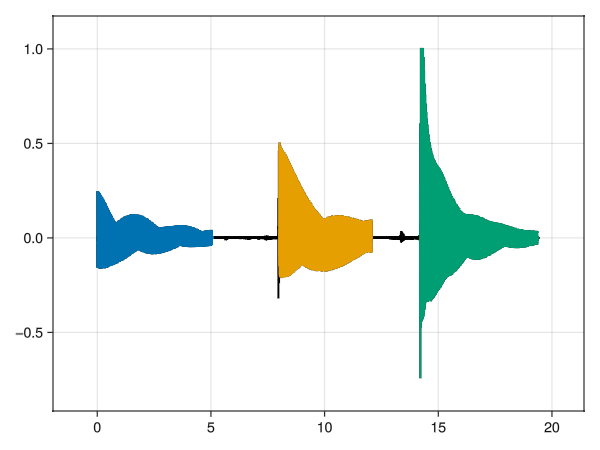

In [10]:
fig = Figure()
ax = Axis(fig[1, 1], yautolimitmargin = (0.1, 0.1), xautolimitmargin = (0.1, 0.1))
lines!(ax, (1:length(y))./Fs, y, color=:black)
for pulse in pulses
    start, energy, max, duration, max_time = pulse
    range = start:(start+duration-1)
    lines!(ax, range./Fs, y[range])
end
fig